In [10]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import backtrader as bt
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import matplotlib.pylab as pylab
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.utils import np_utils

pylab.rcParams['figure.figsize'] = 40, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "40"

In [33]:
def run_backtest(aStrategy, year_start=2015 , year_end=2018 , label="s"):
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    
    # Add a strategy
    cerebro.addstrategy(aStrategy)

    datapath = os.path.join('../../../datas/spx-2013-2018.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(int(year_start), 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(int(year_end), 1, 1),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Write output
    cerebro.addwriter(bt.WriterFile, out='%s.csv'%label,csv=True)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    
    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()

Starting Portfolio Value: 100000.00
2015-02-20, Close, 2110.30 ; Position 0.000000
2015-02-23, Close, 2109.66 ; Position 0.000000
2015-02-24, Close, 2115.48 ; Position 0.000000
2015-02-25, Close, 2113.86 ; Position 0.000000
2015-02-26, Close, 2110.74 ; Position 0.000000
2015-02-27, Close, 2104.50 ; Position 0.000000
2015-03-02, Close, 2117.39 ; Position 0.000000
2015-03-03, Close, 2107.78 ; Position 0.000000
2015-03-04, Close, 2098.53 ; Position 0.000000
2015-03-05, Close, 2101.04 ; Position 0.000000
2015-03-06, Close, 2071.26 ; Position 0.000000
2015-03-09, Close, 2079.43 ; Position 0.000000
2015-03-10, Close, 2044.16 ; Position 0.000000
2015-03-11, Close, 2040.24 ; Position 0.000000
2015-03-11, BUY CREATE, 2040.24
2015-03-12, BUY EXECUTED, 2041.10
2015-03-12, Close, 2065.95 ; Position 4.901384
2015-03-12, [Exit]SELL CREATE, 2065.95
2015-03-13, SELL EXECUTED, 2064.56
2015-03-13, Close, 2053.40 ; Position 0.000000
2015-03-13, BUY CREATE, 2053.40
2015-03-13, SELL CREATE, 2053.40
2015-03

/home/project/workspace/backtrader/backtrader/plot/plot.py:127: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/project/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/project/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/project/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/project/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/project/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self

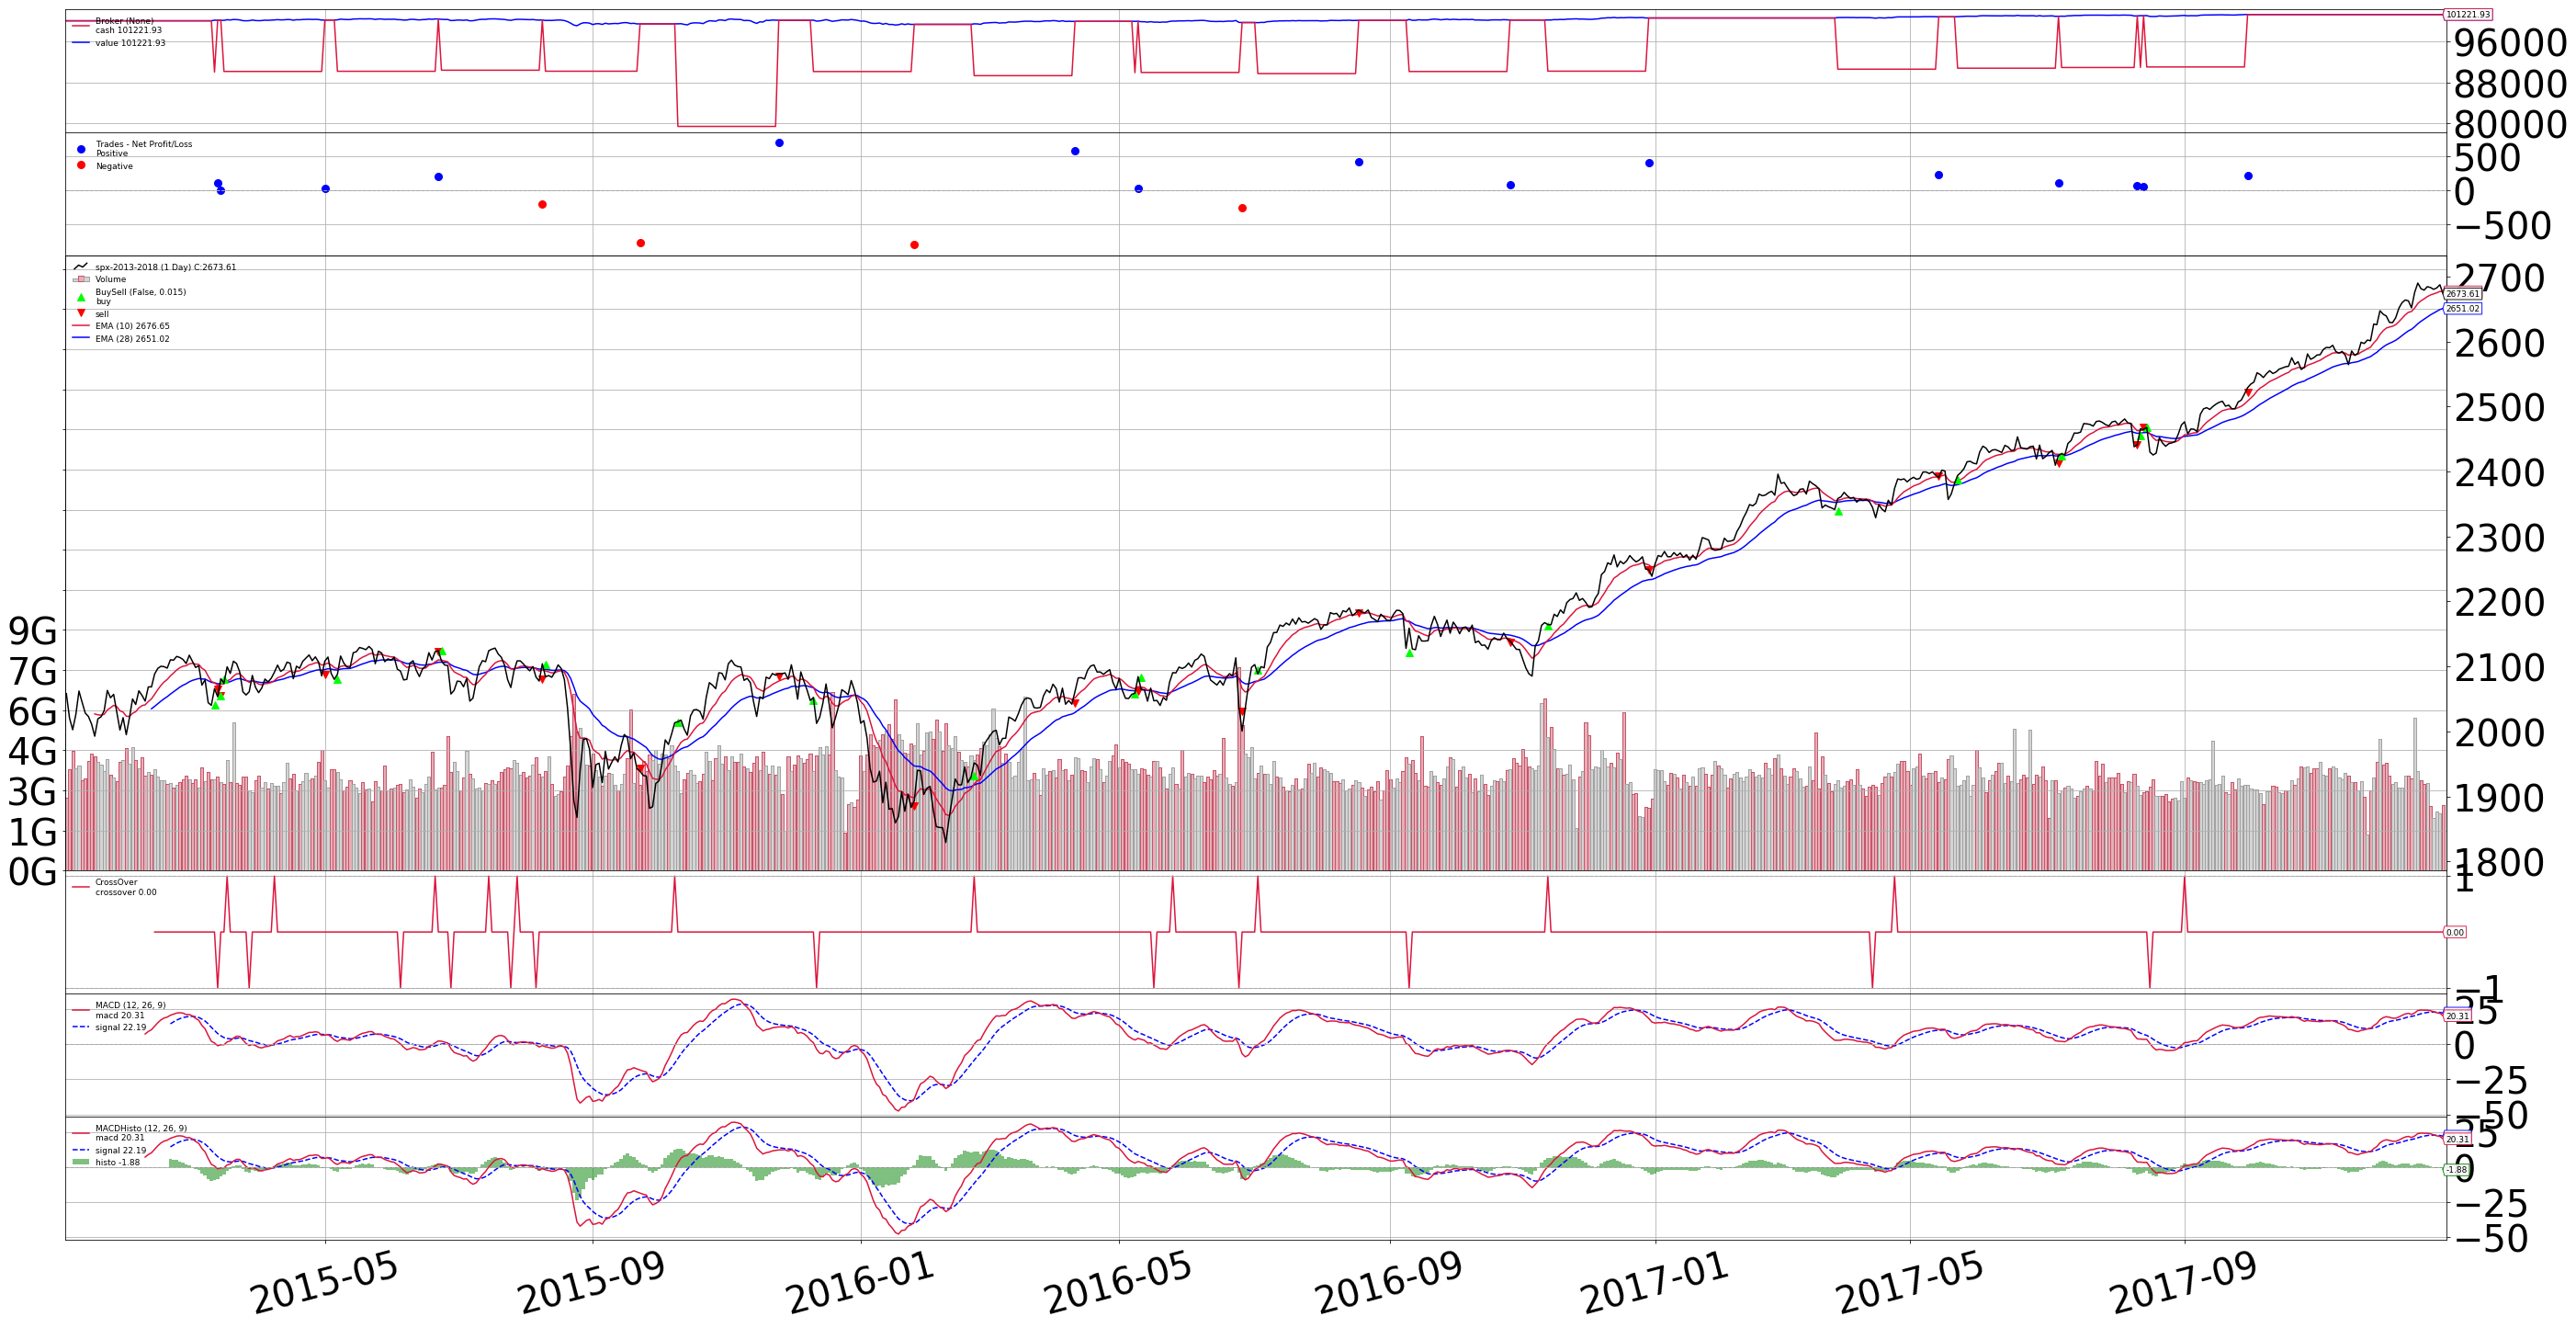

In [34]:
from backtrader.indicators import EMA
"""
price = []
ema_55 = []
ema_21 = []
macd = []
histo = []
signal = []
"""
class MomentumStrategy(bt.Strategy):
    params = (('macd1', 12),
             ('macd2', 26),
             ('macd3', 9),
             ('ema1',10),
             ('ema2',28))
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        self.order = None
        
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.params.macd1,
                                       period_me2=self.params.macd2,
                                       period_signal=self.params.macd3)
        
        self.histo = self.macd.macd - self.macd.signal
        self.hist = bt.indicators.MACDHisto(self.datas[0])
        self.ema_short =  bt.indicators.EMA(self.datas[0], period = self.params.ema1)
        self.ema_long =  bt.indicators.EMA(self.datas[0], period = self.params.ema2)
        self.crossover = bt.indicators.CrossOver(self.ema_short, self.ema_long)
        self.diff = self.ema_short - self.ema_long
        
    def start(self):
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
       
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def next(self):
        """
        histo.append(self.histo[0])
        price.append(self.dataclose[0])
        ema_55.append(self.ema_55[0])
        ema_21.append(self.ema_21[0])
        macd.append(self.macd.macd[0])
        signal.append(self.macd.signal[0])
        print ('crossover',self.crossover[0])
        print ('macd', self.macd.macd[0])
        """
        # Always long or short $10000 securities
        size = 10000./self.dataclose[0]
        
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))
  
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        # Check if we are in the market
        if not self.position:
            #Open position
            
            # BUY if:
            # short line cross long line from below 
            if  self.crossover[0] == 1 :
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                #print (self.histo.get(ago=-1, size=3))
                #print (self.histo.get(ago=0, size=3))
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=size)
             
            # short line converges to long line from below
            if self.diff.get(ago=-1, size=10) < self.diff.get(ago=-2, size=10) and np.abs(self.diff[0])< 5 :
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                #print (self.histo.get(ago=-1, size=3))
                #print (self.histo.get(ago=0, size=3))
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=size)
             
            # short line diverges from long line from above
            if self.diff.get(ago=-1, size=10) > self.diff.get(ago=-2, size=10) and np.abs(self.diff[0])< 5 :
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                #print (self.histo.get(ago=-1, size=3))
                #print (self.histo.get(ago=0, size=3))
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=size)
            
            # SELL if:
             # short line cross long line from above
            if  self.crossover[0] == -1:
                    
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                #print (self.histo.get(ago=-1, size=3))
                #print (self.histo.get(ago=0, size=3))
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=size)
                
                
        #Exit position
        elif self.position.size>0 :
            #Exit the long position
            if len(self) > self.bar_executed+30 or np.all(np.abs(self.diff.get(ago=-1, size=10)) < np.abs(self.diff.get(ago=-2, size=10))):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.close()
       
        elif self.position.size<0:
            #Exit the short position
            if len(self) > self.bar_executed+30 or np.all(np.abs(self.diff.get(ago=-1, size=10)) < np.abs(self.diff.get(ago=-2, size=10))) or self.crossover[0]==1:
            
                self.log('[Exit]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.close()
        
run_backtest(MomentumStrategy)     

In [4]:
import pandas as pd

In [5]:
cross = list(np.array(ema_21) - np.array(ema_55))
initial_indicators = [price, ema_55, ema_21, cross, macd, signal, histo]
initial_indicators = pd.DataFrame(initial_indicators).T
initial_indicators.columns =  ['price','ema_55','ema_21', 'cross', 'macd','signal','histo']
initial_indicators.price = initial_indicators.price.diff()
initial_indicators.ema_21 = initial_indicators.ema_21.diff()
initial_indicators.ema_55 = initial_indicators.ema_55.diff()
initial_indicators.macd = initial_indicators.macd.diff()
initial_indicators.signal = initial_indicators.signal.diff()
initial_indicators.price[initial_indicators.price > 0] = 1
initial_indicators.price[initial_indicators.price <= 0] = 0
initial_indicators = initial_indicators[1:]
initial_indicators.head(10)

NameError: name 'ema_21' is not defined

In [ ]:
length = len(initial_indicators)
# divide into 6 parts
combi = np.arange(0, length, int(length/3))
data = []
for i in range(len(combi)-1):
    data.append(initial_indicators.iloc[combi[i]:combi[i+1]])
    print (len(initial_indicators.iloc[combi[i]:combi[i+1]]))

In [ ]:
def scale(train, test):
    # fit scaler
    a,b,c = train.shape
    train = train.reshape(a * b, c)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    #train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    train_scaled = train_scaled.reshape(a,b,c)
    # transform test
    e,f,g = test.shape
    test = test.reshape(e * f, g)
    test_scaled = scaler.transform(test)
    test_scaled = test_scaled.reshape(e,f,g)
    print (train_scaled.shape)
    print (test_scaled.shape)
    return scaler, train_scaled, test_scaled

In [ ]:
len(data)

In [ ]:
for i in range(len(data)):
    item = data[i]
    ratio = .9
    offset = 5
    # past 6 days

    features = []
    labels = []

    item.index = np.arange(len(item))

    for i in range(offset, len(item)-1):
        feature = item.loc[i-offset:i,:].values
        features.append(feature)
        label = item.loc[i+1,'price']
        labels.append(label)
        
    train_len = int (len(labels) * ratio)
    train_x = np.array(features[:train_len])
    train_y = np_utils.to_categorical(np.array(labels[:train_len]))
    test_x_1 = np.array(features[train_len+1:])
    test_y_1 = np_utils.to_categorical(np.array(labels[train_len+1:]))


    _, train_x_scale, test_x_scale= scale(train_x, test_x_1)
    #train_y = np.reshape(train_y, (train_y.shape[0], 1))
    #test_y = np.reshape(test_y, (test_y.shape[0], 1))
    model1 = Sequential()
    model1.add(LSTM(32, input_shape=(6,7), return_sequences=False, stateful=False))
    model1.add(Dropout(0.2))
    model1.add(Dense(train_y.shape[1], activation='softmax'))
    model1.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    model1.fit(train_x, train_y,  batch_size=16,  epochs=50)
    print (model1.evaluate(test_x_1, test_y_1, batch_size=16))

In [ ]:
price_diff = np.diff(price)
price_diff = np.r_[price_diff,[0]]
price_diff[price_diff > 0] = 1
price_diff[price_diff < 0] = 0

ema_diff = np.array(ema_21) - np.array(ema_55)

In [ ]:
indicator = [price_diff, ema_diff, macd, histo, signal]
price
for i in indicator:
    print (len(i))

In [ ]:
indicators = pd.DataFrame(indicator).T

In [ ]:
indicators.columns = ['price_diff','ema_diff','macd','hist','signal']
indicators.head(10)
indicators[:100].plot(figsize=(14,10))

In [ ]:
length = len(indicators)
# divide into 6 parts
combi = np.arange(0, length, int(length/4))
data = []
for i in range(len(combi)-1):
    data.append(indicators.iloc[combi[i]:combi[i+1]])
    print (len(indicators.iloc[combi[i]:combi[i+1]]))

In [ ]:
def scale(train, test):
    # fit scaler
    a,b,c = train.shape
    train = train.reshape(a * b, c)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    #train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    train_scaled = train_scaled.reshape(a,b,c)
    # transform test
    e,f,g = test.shape
    test = test.reshape(e * f, g)
    test_scaled = scaler.transform(test)
    test_scaled = test_scaled.reshape(e,f,g)
    print (train_scaled.shape)
    print (test_scaled.shape)
    return scaler, train_scaled, test_scaled

In [ ]:
for i in range(len(data)):
    item = data[i]
    ratio = .9
    offset = 5
    # past 6 days

    features = []
    labels = []

    item.index = np.arange(len(item))

    for i in range(offset, len(item)):
        feature = item.loc[i-offset:i,'ema_diff':'signal'].values
        features.append(feature)
        label = item.loc[i,'price_diff']
        labels.append(label)
        
    train_len = int (len(labels) * ratio)
    train_x = np.array(features[:train_len])
    train_y = np_utils.to_categorical(np.array(labels[:train_len]))
    test_x_2 = np.array(features[train_len+1:])
    test_y_2 = np_utils.to_categorical(np.array(labels[train_len+1:]))


    _, train_x_scale, test_x_scale= scale(train_x, test_x_2)
    #train_y = np.reshape(train_y, (train_y.shape[0], 1))
    #test_y = np.reshape(test_y, (test_y.shape[0], 1))
    model2 = Sequential()
    model2.add(LSTM(32, input_shape=(6,4), return_sequences=False, stateful=False, use_bias=True))
    model2.add(Dropout(0.2))
    model2.add(Dense(train_y.shape[1], activation='softmax'))
    model2.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    model2.fit(train_x, train_y,  batch_size=16,  epochs=50)
                 
    print (model2.evaluate(test_x_2, test_y_2, batch_size=16))